# Tutorial: t-test

## Goal

As with the Z-test, the one sample t-test tests whether a sample belongs to a population or to a shifted version, along the x axis, of the same population.

## When to Use t-test instead of z-test

The choice between a $ t $-test and $ z $-test typically revolves around two key factors:

1. **Unknown population standard deviation**: 
    - If the population standard deviation ($ \sigma $) is known, the $ z $-test is more appropriate. 
    - If $ \sigma $ is not known and instead we estimate it using the sample standard deviation ($ s $), the $ t $-test is more appropriate.

2. **Small sample size (n < 30)**: 
    - For larger samples (often cited as $ n > 30 $), the sample standard deviation ($ s $) can be a good estimate for the population standard deviation, and the $ t $-distribution approximates the normal distribution. 
    - Thus, for large samples, even if you don't know $ \sigma $, you might still use a $ z $-test.

## Formulas:

**For z-test:**
$$ z = \frac{sample \space statistics - hypothesized \space population \space parameter}{estimated \space standard \space error} $$

$$ z = \frac{\bar{x} - \mu}{\sigma/\sqrt{n}} $$
Where:
- $ \bar{x} $ = sample mean
- $ \mu $ = population mean
- $ \sigma $ = population standard deviation
- $ n $ = sample size

**For t-test:**
$$ t = \frac{sample \space statistics - hypothesized \space population \space parameter}{estimated \space standard \space error} $$

$$ t = \frac{\bar{x} - \mu}{s/\sqrt{n}} $$
Where:
- $ \bar{x} $ = sample mean
- $ \mu $ = population (or expected) mean
- $ s $ = sample standard deviation
- $ n $ = sample size

> **Note**: The critical value (i.e., the value beyond which we would reject the null hypothesis) for a given significance level will be different between the $ t $-distribution and the normal distribution. It's crucial to refer to the appropriate table or statistical software to determine this value.


## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t, norm, ttest_1samp, ttest_ind, beta
from scipy.optimize import fsolve
from scipy import stats

## Comparison z- and t-distributions

Degrees of freedom (df) = sample size (n) - 1

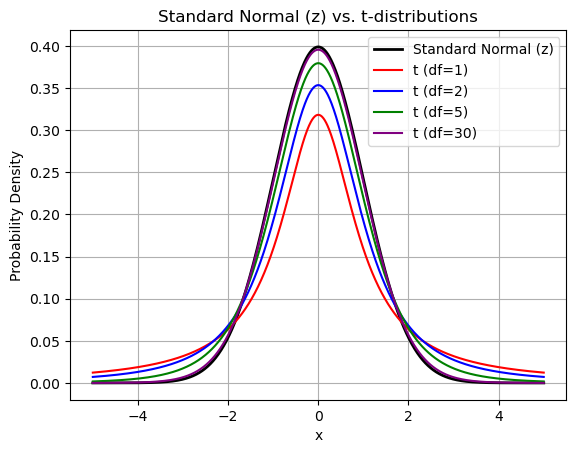

In [2]:
# Define x values
x = np.linspace(-5, 5, 1000)

# Standard normal (z-distribution) pdf
z_pdf = norm.pdf(x)

# Plot z-distribution
plt.plot(x, z_pdf, label='Standard Normal (z)', color='black', linewidth=2)

# Plot t-distributions for different degrees of freedom
dfs = [1, 2, 5, 30]  # Degrees of freedom
colors = ['red', 'blue', 'green', 'purple']

for df, color in zip(dfs, colors):
    t_pdf = t.pdf(x, df)
    plt.plot(x, t_pdf, label=f't (df={df})', color=color)

plt.title('Standard Normal (z) vs. t-distributions')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()


### Estimation of standard errors when $\sigma$ is known vs unknown

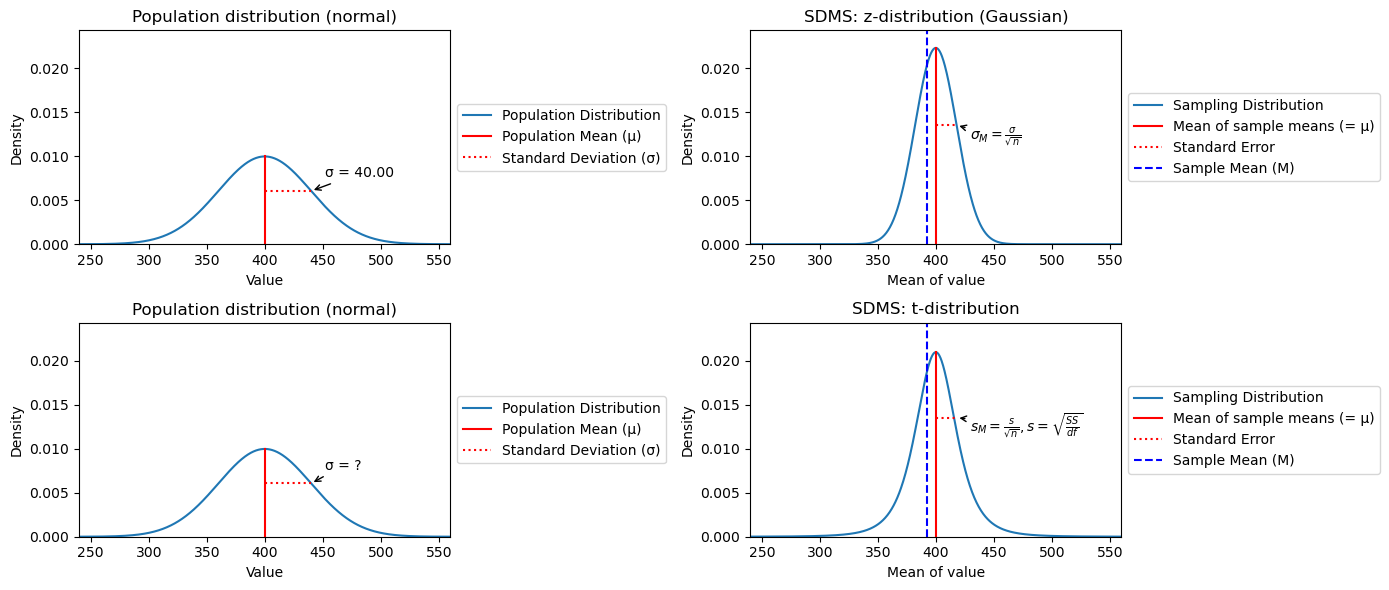

In [22]:
# Given values
mu = 400          # Population mean
sigma = 40        # Population standard deviation
sample_mean = 392 # Sample mean
n = 5             # Sample size
sample_std = sigma / np.sqrt(n)  # Standard error (std. deviation of sample means)
df = n - 1        # Degrees of freedom for t-distribution

# Generate data for plotting
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)

# Now using a Gaussian for population distribution
y = norm.pdf(x, mu, sigma)

y_sample = norm.pdf(x, mu, sample_std)
y_tdist = t.pdf(x, df, mu, sample_std) # t-distribution

# Define the plots in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 6))

# Adjust xlim and ylim for all plots
xlims = (min(x), max(x))
ylims = (0, max(y_sample) + 0.002)

def plot_population_distribution(ax, title, sigma_text):
    ax.plot(x, y, label='Population Distribution')
    ax.plot([mu, mu], [0, norm.pdf(mu, mu, sigma)], 'red', label='Population Mean (μ)')
    
    # Adjusting the horizontal line for standard deviation
    height_at_sigma = norm.pdf(mu + sigma, mu, sigma)
    ax.hlines(y=height_at_sigma, xmin=mu, xmax=mu+sigma, color='red', linestyle=':', label='Standard Deviation (σ)')
    ax.annotate(sigma_text, xy=(mu + sigma, height_at_sigma), xytext=(10,10), textcoords='offset points', arrowprops=dict(arrowstyle="->"), fontsize=10)
    
    ax.set_title(title)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")

def plot_sampling_distribution(ax, y_data, title, annotation):
    if y_data is y_sample:  # If it's a normal distribution
        height_at_mu = norm.pdf(mu, mu, sample_std)
    else:  # If it's a t-distribution
        height_at_mu = t.pdf(mu, df, mu, sample_std)

    ax.plot(x, y_data, label='Sampling Distribution')
    ax.plot([mu, mu], [0, height_at_mu], 'red', label='Mean of sample means (= μ)')
    ax.hlines(y=norm.pdf(mu + sample_std, mu, sample_std), xmin=mu, xmax=mu+sample_std, linestyle=':', color='red', label='Standard Error')
    ax.axvline(x=sample_mean, color='blue', linestyle='--', label='Sample Mean (M)')
    ax.annotate(annotation, xy=(mu + sample_std, norm.pdf(mu + sample_std, mu, sample_std)), xytext=(10,-10), textcoords='offset points', arrowprops=dict(arrowstyle="->"), fontsize=10)
    ax.set_title(title)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_xlabel("Mean of value")
    ax.set_ylabel("Density")

# UPPER LEFT: Population Distribution (Gaussian)
plot_population_distribution(axes[0,0], 'Population distribution (normal)', f'σ = {sigma:.2f}')

# UPPER RIGHT: Sampling Distribution of the Sample Means (Normal Distribution)
plot_sampling_distribution(axes[0,1], y_sample, 'SDMS: z-distribution (Gaussian)', r'$\sigma_M = \frac{\sigma}{\sqrt{n}}$')

# LOWER LEFT: Population Distribution (Gaussian)
plot_population_distribution(axes[1,0], 'Population distribution (normal)', 'σ = ?')

# LOWER RIGHT: Sampling Distribution of the Sample Means (t-distribution)
plot_sampling_distribution(axes[1,1], y_tdist, 'SDMS: t-distribution', r'$s_M = \frac{s}{\sqrt{n}},  s = \sqrt{\frac{SS}{df}}$')

plt.tight_layout()
plt.show()

# Delete all variables of this block
del mu, sigma, sample_mean, n, sample_std, df, x, y, y_sample, y_tdist, fig, axes, xlims, ylims


## Assumptions of the t-test

1. **Normality**: 
    - The populations should be approximately normally distributed. For smaller sample sizes, this assumption is crucial, but as the sample size increases, thanks to the Central Limit Theorem, the $ t $-test becomes more robust to violations of this assumption.
    
2. **Homogeneity of Variances** (for independent two-sample $ t $-test):
    - This assumption, also known as homoscedasticity, means that the variances in the two groups being compared should be roughly equal. If they're not, a variation of the $ t $-test known as Welch's $ t $-test might be more appropriate.
    
3. **Random Sampling**:
    - The data should be derived from a random sample. This ensures that the results are likely representative of the larger population and not influenced by biases.

4. **Independence of Observations**:
    - Each observation (or data point) should be independent of all others. In the context of the paired $ t $-test, the differences between pairs are independent.

5. **Scale of Measurement**:
    - The $ t $-test assumes that the dependent variable is measured on at least an interval scale. This means that there should be consistent intervals between scores on the measured outcome.

6. **Absence of Outliers**:
    - The $ t $-test can be sensitive to outliers. Extreme values can unduly influence the results of the test. Before performing the test, it's advisable to check for and handle potential outliers.

Always verify these assumptions for your specific data before conducting a $ t $-test to ensure the validity of your results.



## Types of t-tests

1. **One-sample t-test**:
    - This test determines if the mean of a single sample is statistically significantly different from a known or hypothesized population mean. <br>
    REMARK: In this test, the sample standard deviation $ s $ is used as an unbiased estimator for the population standard deviation $ \sigma $ when the degrees of freedom are large, because then the t-distribution approximates a normal distribution and the central limit theorem can be applied.
    
    - Formula: 
    $$ t = \frac{\bar{x} - \mu_0}{s / \sqrt{n}} $$
    Where:
        - $ \bar{x} $ is the sample mean.
        - $ \mu_0 $ is the known or hypothesized population mean.
        - $ s $ is the sample standard deviation.
        - $ n $ is the sample size.

2. **Two-sample independent (or unpaired) t-test**:
    - Compares the means of two independent samples to determine if they are statistically significantly different.
    - Assumes equal variances (homoscedasticity). For unequal variances, consider Welch's t-test.
    - Formula:
    $$ t = \frac{\bar{x}_1 - \bar{x}_2}{\sqrt{\frac{s^2_1}{n_1} + \frac{s^2_2}{n_2}}} $$
    Where:
        - $ \bar{x}_1 $ and $ \bar{x}_2 $ are the sample means of groups 1 and 2.
        - $ s_1^2 $ and $ s_2^2 $ are the sample variances of groups 1 and 2.
        - $ n_1 $ and $ n_2 $ are the sample sizes of groups 1 and 2.

3. **Paired (or dependent) t-test**:
    - Compares the means of the same group or item under two separate scenarios. Commonly used for "before-and-after" scenarios, such as measuring a metric before and after an intervention.
    - Formula:
    $$ t = \frac{\bar{d}}{s_d / \sqrt{n}} $$
    Where:
        - $ \bar{d} $ is the mean of the paired differences.
        - $ s_d $ is the standard deviation of the paired differences.
        - $ n $ is the number of paired observations.

4. **Welch's t-test**:
    - A variation of the two-sample t-test which is more reliable when the two samples have unequal variances and unequal sample sizes.

## Checking t-test assumptions

1. **Independence of observations**: This is generally a design feature of the study. If you've randomly selected your two samples and they don't have a paired or dependent relationship, then you've met this assumption. Ensure that the experimental design or sampling method produces independent observations.

2. **Normality**: We can use the Shapiro-Wilk test to test for normality.

2. **Homogeneity of Variance (for more than one group)**: We can use the Levene's test to check for this.

A few points to remember:

* A p-value greater than 0.05 from the Shapiro-Wilk test suggests the data is normally distributed.
* A p-value greater than 0.05 from the Levene's test suggests the groups have equal variances.
* These tests do not "prove" normality or equal variance, but rather provide evidence to not reject these assumptions. Always combine these tests with graphical methods (e.g., histograms or Q-Q plots) for more robust inference about your data's structure.

## Example of a one-sample t-test

Suppose a teacher expected her class to score an average of 50 on a test. She collects the results and wants to determine if the actual mean score is statistically different from 50.

#### Create simulated data

Scores = [51 64 59 55 52 65 51 63 55 55 65 48 52 47 65 46 56 50 46 65 45 56 56 61
 54]


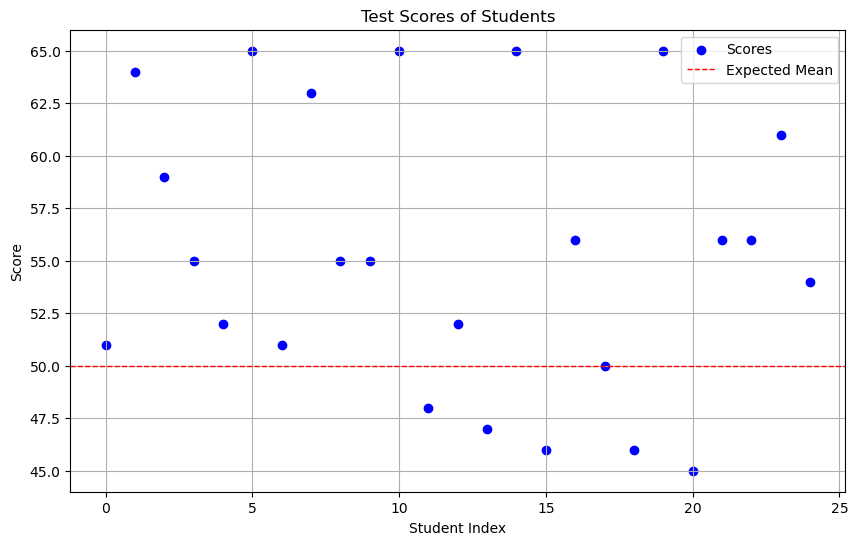

In [4]:
sample_mean = 55
sample_size =25
sample_std = 10

expected_mean = 50
alpha = 0.05

test_type = 'two-tails' # 'two-tails', 'one-tail'

###
np.random.seed(42)  # For reproducibility

# Generate random integer scores
scores = np.random.randint(sample_mean - sample_std, sample_mean + sample_std + 1, sample_size)

print(f"Scores = {scores}")

plt.figure(figsize=(10,6))
x = np.arange(len(scores))
plt.scatter(x, scores, color='blue', label='Scores')
plt.axhline(50, color='red', linestyle='dashed', linewidth=1, label='Expected Mean')
plt.title('Test Scores of Students')
plt.xlabel('Student Index')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

#### Check for data normality

In [5]:
def check_normality(scores):
    # Checking for Normality of scores
    _, shapiro_p = stats.shapiro(scores)
    
    if shapiro_p > 0.05:
        print("Scores: Data follows a normal distribution")
    else:
        print("Scores: Data does not follow a normal distribution")

# Example usage:
check_normality(scores)


Scores: Data follows a normal distribution


#### [Optional] Plot a z-distribution with unknown $\sigma$

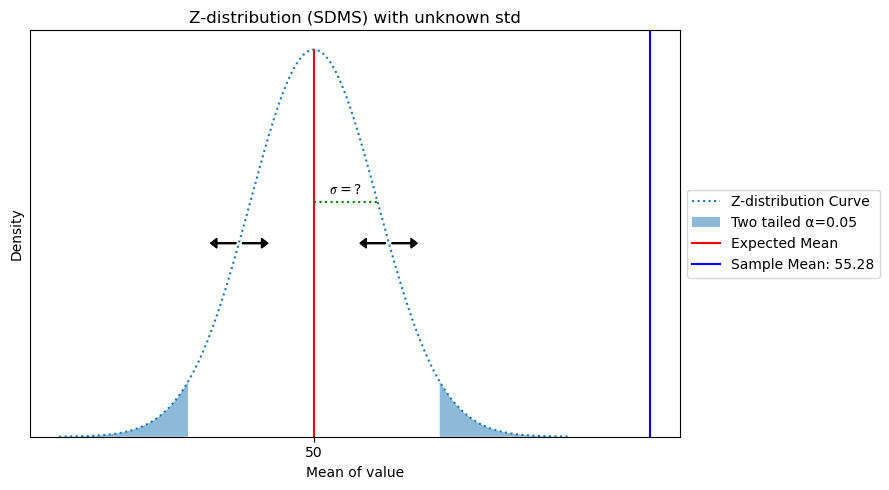

In [6]:
def z_distribution_unknown_std(data, expected_mean, alpha=0.05):
    
    # Calculate the sample mean
    sample_mean = np.mean(data)

    # Create Z-distribution curve
    x = np.linspace(expected_mean - 4, expected_mean + 4, 400)
    y = norm.pdf(x, loc=expected_mean, scale=1)

    # Maximum height of Z-distribution
    y_max = max(y)

    # Calculate height of Z-distribution curve at expected_mean + 1 (i.e., 1 standard deviation away)
    y_intercept = norm.pdf(expected_mean + 1, loc=expected_mean, scale=1)

    # Find intersection points using vectorized approach
    mid_height_y = y_max / 2
    intersections = np.abs(y - mid_height_y)
    mid_height_x_left = x[np.argmin(intersections[:len(intersections)//2])]
    mid_height_x_right = x[np.argmin(intersections[len(intersections)//2:]) + len(intersections)//2]

    # Critical values for shading
    left_critical = expected_mean + norm.ppf(alpha/2)
    right_critical = expected_mean + norm.ppf(1 - alpha/2)

    # Arrow properties
    arrow_length = 0.3

    # Create the plot
    plt.figure(figsize=(9, 5))

    # Plot Z-distribution curve
    plt.plot(x, y, linestyle=':', label='Z-distribution Curve')

    # Shade the tails
    plt.fill_between(x, y, where=(x < left_critical) | (x > right_critical), alpha=0.5, label=f'Two tailed α={alpha}')

    # Draw arrows using plt.arrow
    plt.arrow(mid_height_x_right+0.05, mid_height_y, arrow_length, 0, head_width=0.01, head_length=0.1, fc='k', ec='k')
    plt.arrow(mid_height_x_right-0.05, mid_height_y, -arrow_length, 0, head_width=0.01, head_length=0.1, fc='k', ec='k')
    plt.arrow(mid_height_x_left+0.05, mid_height_y, arrow_length, 0, head_width=0.01, head_length=0.1, fc='k', ec='k')
    plt.arrow(mid_height_x_left-0.05, mid_height_y, -arrow_length, 0, head_width=0.01, head_length=0.1, fc='k', ec='k')

    # Plot red vertical line from 0 to its intersection with Z-distribution
    plt.plot([expected_mean, expected_mean], [0, y_max], color='red', label='Expected Mean')

    # Plot blue vertical line for the sample mean
    plt.axvline(sample_mean, color='blue', linestyle='-', label=f'Sample Mean: {sample_mean:.2f}')

    # Plot green line representing 1 standard deviation and add question mark annotation
    plt.plot([expected_mean, expected_mean + 1], [y_intercept, y_intercept], color='green', linestyle=':')
    plt.text(expected_mean + 0.5, y_intercept + 0.005, r'$𝜎 = ?$', ha='center', va='bottom', fontsize=10)
    
    # Only show expected mean on x-axis and hide all other tick labels
    plt.xticks([expected_mean], [f"{expected_mean}"])
    plt.yticks([])

    # Title, labels, legend, and y limits
    plt.title('Z-distribution (SDMS) with unknown std')
    plt.xlabel('Mean of value')
    plt.ylabel('Density')
    plt.ylim(0)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()


### MAIN ###
z_distribution_unknown_std(scores, expected_mean, alpha)

#### [Optional] Plot a t-distribution with unknown $\sigma$

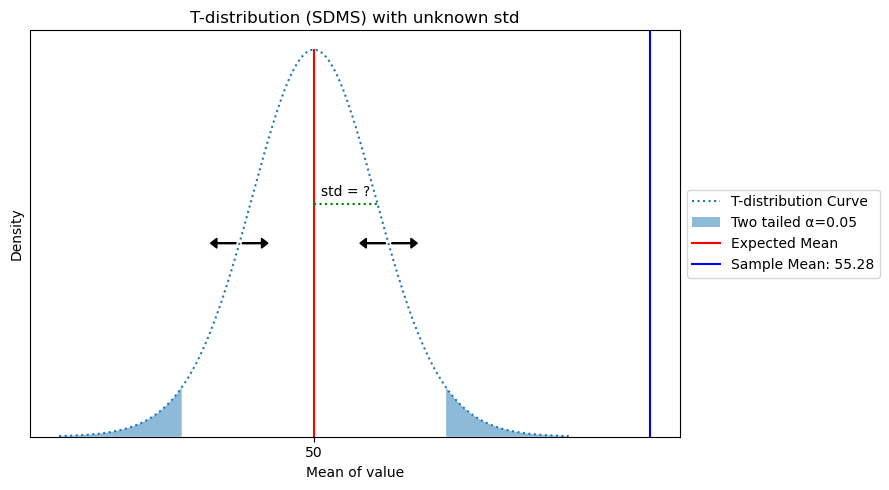

In [7]:
def t_distribution_unknown_std(data, expected_mean, alpha=0.05):
    
    # Calculate the sample mean and degrees of freedom
    sample_mean = np.mean(data)
    df = len(data) - 1  # degrees of freedom for t-distribution

    # Create t-distribution curve
    x = np.linspace(expected_mean - 4, expected_mean + 4, 400)
    y = t.pdf(x, df, loc=expected_mean, scale=1)

    # Maximum height of t-distribution
    y_max = max(y)

    # Calculate height of t-distribution curve at expected_mean + 1 (i.e., 1 standard deviation away)
    y_intercept = t.pdf(expected_mean + 1, df, loc=expected_mean, scale=1)

    # Find intersection points using vectorized approach
    mid_height_y = y_max / 2
    intersections = np.abs(y - mid_height_y)
    mid_height_x_left = x[np.argmin(intersections[:len(intersections)//2])]
    mid_height_x_right = x[np.argmin(intersections[len(intersections)//2:]) + len(intersections)//2]

    # Critical values for shading
    left_critical = expected_mean + t.ppf(alpha/2, df)
    right_critical = expected_mean + t.ppf(1 - alpha/2, df)

    # Arrow properties
    arrow_length = 0.3

    # Create the plot
    plt.figure(figsize=(9, 5))

    # Plot t-distribution curve
    plt.plot(x, y, linestyle=':', label='T-distribution Curve')

    # Shade the tails
    plt.fill_between(x, y, where=(x < left_critical) | (x > right_critical), alpha=0.5, label=f'Two tailed α={alpha}')

    # Draw arrows using plt.arrow
    plt.arrow(mid_height_x_right+0.05, mid_height_y, arrow_length, 0, head_width=0.01, head_length=0.1, fc='k', ec='k')
    plt.arrow(mid_height_x_right-0.05, mid_height_y, -arrow_length, 0, head_width=0.01, head_length=0.1, fc='k', ec='k')
    plt.arrow(mid_height_x_left+0.05, mid_height_y, arrow_length, 0, head_width=0.01, head_length=0.1, fc='k', ec='k')
    plt.arrow(mid_height_x_left-0.05, mid_height_y, -arrow_length, 0, head_width=0.01, head_length=0.1, fc='k', ec='k')

    # Plot red vertical line from 0 to its intersection with t-distribution
    plt.plot([expected_mean, expected_mean], [0, y_max], color='red', label='Expected Mean')

    # Plot blue vertical line for the sample mean
    plt.axvline(sample_mean, color='blue', linestyle='-', label=f'Sample Mean: {sample_mean:.2f}')

    # Plot green line representing 1 standard deviation and add question mark annotation
    plt.plot([expected_mean, expected_mean + 1], [y_intercept, y_intercept], color='green', linestyle=':')
    plt.text(expected_mean + 0.5, y_intercept + 0.005, 'std = ?', ha='center', va='bottom', fontsize=10)
    
    # Only show expected mean on x-axis and hide all other tick labels
    plt.xticks([expected_mean], [f"{expected_mean}"])
    plt.yticks([])

    # Title, labels, legend, and y limits
    plt.title('T-distribution (SDMS) with unknown std')
    plt.xlabel('Mean of value')
    plt.ylabel('Density')
    plt.ylim(0)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

    
### MAIN ###
t_distribution_unknown_std(scores, expected_mean, alpha)

#### Perform a one-sample t-test

- $H_0$: $\mu=50$
- $H_1$: $\mu\neq50$
<br>

##### In principle, we could find the p-value of our sample simply by calculating the t-score. However, if we are calculating it manually, we use a statistical table to verify the position of the sample-tscore with the t-score of the alpha. In that case, we need to calculate 2 things: <br>
**1. the t-score of corresponding to the alpha of our sample size** <br>
Just consult the statistical table: 
- Find the appropriate degrees of freedom (df) row in the t-distribution table.
- Move horizontally across that row until you find the range in which your calculated t-score falls.
- Annotate the value corresponding to either a one-tailed or two-tailed distribution
    
**2. the t-score of our sample mean**
- **t-statistic**:
$$ t = \frac{M - \mu}{s_M} $$
Where $M$ is the sample mean, $\mu$ is the hypothesized population mean and $s^2$ is the sample variance

- **Estimated Standard Error ($s_M$)**:
$$ s_M = \sqrt{\frac{s^2}{n}} $$
Where $s^2$ is the sample variance and $n$ is the sample size.

- **Sample Variance ($s^2$)**:
$$ s^2 = \frac{SS}{df} $$
Where $df$ is the degrees of freedom, which is typically $n - 1$ for a sample variance, and SS is the Sum of Squared Deviations

- **Sum of Squared Deviations (SS)**:
$$ SS = \sum (X_i - \bar{X})^2 $$
Where $ X_i $ represents the $i^{th}$ individual data point in the sample and $ \bar{X} $ is the sample mean

#### The t-distribution table

In [8]:
# Define the significance levels for one-tailed tests
alpha_values_one_tail = [0.25, 0.1, 0.05, 0.025, 0.01, 0.005]

# Convert them to two-tailed values (double the one-tail values)
alpha_values_two_tail = [alpha * 2 for alpha in alpha_values_one_tail]

# Define degrees of freedom range
df_range = list(range(1, 31))

# Populate the table
data = {}
for alpha_1, alpha_2 in zip(alpha_values_one_tail, alpha_values_two_tail):
    t_values = [t.ppf(1 - alpha_2/2, df) for df in df_range]  # Adjusted to take the correct percentile for two-tail alpha values
    data[(f'One-tail: α = {alpha_1}' if alpha_1 == 0.25 else f'α = {alpha_1}', 
         f'Two-tails: α = {alpha_2}' if alpha_2 == 0.5 else f'α = {alpha_2}')] = t_values

# Create dataframe
t_table = pd.DataFrame(data, index=df_range)
t_table.index.name = "Degrees of Freedom"
t_table.name = "T-Distribution Table"

display(t_table)


,One-tail: α = 0.25,α = 0.1,α = 0.05,α = 0.025,α = 0.01,α = 0.005
,Two-tails: α = 0.5,α = 0.2,α = 0.1,α = 0.05,α = 0.02,α = 0.01
Degrees of Freedom,,,,,,
1,1.000000,3.077684,6.313752,12.706205,31.820516,63.656741
2,0.816497,1.885618,2.919986,4.302653,6.964557,9.924843
3,0.764892,1.637744,2.353363,3.182446,4.540703,5.840909
4,0.740697,1.533206,2.131847,2.776445,3.746947,4.604095
5,0.726687,1.475884,2.015048,2.570582,3.364930,4.032143
6,0.717558,1.439756,1.943180,2.446912,3.142668,3.707428
7,0.711142,1.414924,1.894579,2.364624,2.997952,3.499483
8,0.706387,1.396815,1.859548,2.306004,2.896459,3.355387


#### Look up t-value on t-table

In [9]:
def lookup_t_value(df, alpha, test_type="two-tails"):
    
    if df not in t_table.index:
        raise ValueError(f"The degrees of freedom {df} does not exist in the table.")
    
    if test_type == "two-tails":
        if alpha not in [0.5, 0.2, 0.1, 0.05, 0.02, 0.01]:
            raise ValueError(f"The alpha value {alpha} does not exist in the table for a two-tailed test.")
    elif test_type == "one-tail":
        if alpha not in [0.25, 0.1, 0.05, 0.025, 0.01, 0.005]:
            raise ValueError(f"The alpha value {alpha} does not exist in the table for a one-tailed test.")
    else:
        raise ValueError("test_type should be either 'one-tail' or 'two-tails'.")
    
    # Determine which level of the multi-index to look in based on test_type
    if test_type == "one-tail":
        # Upper level for one-tail
        column_label = f'α = {alpha}'
        if column_label not in t_table.columns.get_level_values(0):
            column_label = 'One-tail: ' + column_label
        return t_table.xs(key=column_label, axis=1, level=0).loc[df].values[0]
    elif test_type == "two-tails":
        # Lower level for two-tails
        column_label = f'α = {alpha}'
        if column_label not in t_table.columns.get_level_values(1):
            column_label = 'Two-tails: ' + column_label
        return t_table.xs(key=column_label, axis=1, level=1).loc[df].values[0]

#### "Manual" calculation

In [10]:
def sum_squared_deviations(np_array):
    mean_val = np.mean(np_array)
    deviations = np_array - mean_val
    squared_deviations = deviations**2
    ss = np.sum(squared_deviations)
    return  ss

def sample_variance(df, sum_squared_deviations):
    if df <= 0:
        raise ValueError("Degrees of freedom must be greater than 0.")
    return sum_squared_deviations / df

def estimated_standard_error(sample_var, n):
    if n <= 1:
        raise ValueError("Sample size must be greater than 1.")
    return np.sqrt(sample_var / n)

def t_score(sample_mean, expected_mean, estimated_standard_error):
    t = (sample_mean - expected_mean) / estimated_standard_error
    return t

#[Optional]
def critical_values(t_alpha, expected_mean, estimated_standard_error):
    left_critical =  expected_mean - t_alpha * estimated_standard_error
    right_critical = expected_mean + t_alpha * estimated_standard_error
    return left_critical, right_critical


### MAIN ###

# Sum of squared deviations
sum_sq_dev = sum_squared_deviations(scores)

# Sample Variance
n = len(scores)
df = n-1
sample_var = sample_variance(df, sum_sq_dev)

# Estimated Standard Error
est_std_err = estimated_standard_error(sample_var, n)
print(est_std_err)
# t-statistic
sample_mean = np.mean(scores)
t_sample = t_score(sample_mean, expected_mean, est_std_err)

# t value at the required alpha
t_alpha = lookup_t_value(df, alpha, test_type)

# Find the critical values
left_critical, right_critical = critical_values(t_alpha, expected_mean, est_std_err)

print(f"t = {t_sample}")
print(f"t({df}) at alpha = {t_alpha}")
print('')
if (sample_mean >= expected_mean and t_sample >= t_alpha) or (sample_mean < expected_mean and t_sample < t_alpha):   
     print(f"RESULT: t({df}) = {t_sample}, p <= {alpha}, so we reject H0. The average score of the class, {sample_mean}, is significantly different from {expected_mean}.")
else:
     print(f"RESULT: t({df}) = {t_sample}, p > {alpha}, so we DON'T reject H0. The average score of the class, {sample_mean}, is NOT significantly different from {expected_mean}.")
print('')
print(f"Left critical value = {left_critical}\nRight critical value = {right_critical}")

1.3222707740852477
t = 3.9931306835793348
t(24) at alpha = 2.0638985616280205

RESULT: t(24) = 3.9931306835793348, p <= 0.05, so we reject H0. The average score of the class, 55.28, is significantly different from 50.

Left critical value = 47.270967251282684
Right critical value = 52.729032748717316


#### Automatic calculation

In [11]:
t_stat, p_value = ttest_1samp(scores, expected_mean)
print(f"df = {len(x)-1}\nt = {t_stat}\np = {p_value}")
print('')
if p_value < 0.05:
    print(f"RESULT: The p-value is {p_value:.4f}. This is less than {alpha}, so we reject H0. The average score of the class, {sample_mean}, is significantly different from {expected_mean}.")
else:
    print(f"RESULT: The p-value is {p_value:.4f}. This is more than {alpha}, so we DON'T reject H0. The average score of the class, {sample_mean}, is NOT significantly different from {expected_mean}.")

df = 24
t = 3.9931306835793348
p = 0.0005361328451478368

RESULT: The p-value is 0.0005. This is less than 0.05, so we reject H0. The average score of the class, 55.28, is significantly different from 50.


#### Automatic calculation with plot

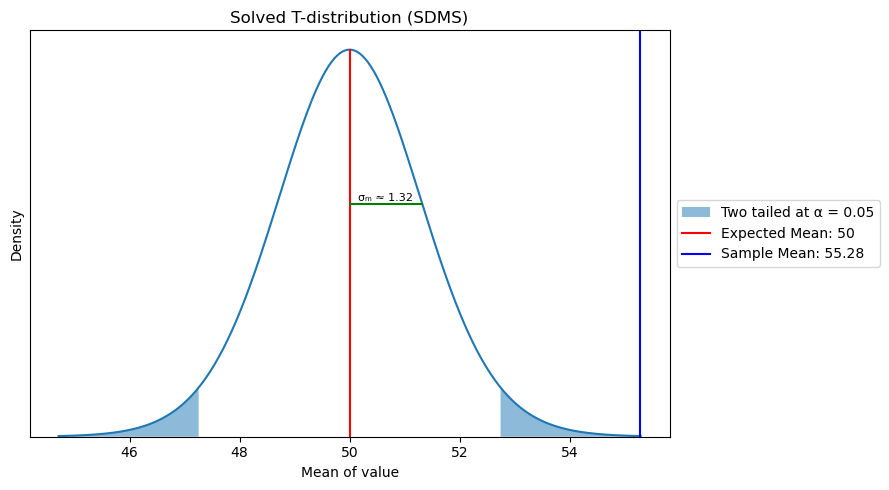

In [12]:
def t_distribution(data, expected_mean, alpha=0.05):
    # Calculate the sample mean, standard deviation, and standard error
    sample_mean = np.mean(data)
    s = np.std(data, ddof=1)
    n = len(data)
    estimated_std = s / np.sqrt(n)
    
    # Degrees of freedom for t-distribution
    df = n - 1

    # Create t-distribution curve
    x = np.linspace(expected_mean - 4*estimated_std, expected_mean + 4*estimated_std, 400)
    y = t.pdf(x, df, loc=expected_mean, scale=estimated_std)

    # Maximum height of t-distribution
    y_max = max(y)

    # Calculate height of t-distribution curve at expected_mean + 1 estimated standard deviation
    y_intercept = t.pdf(expected_mean + estimated_std, df, loc=expected_mean, scale=estimated_std)

    # Critical values for shading
    left_critical = expected_mean + t.ppf(alpha/2, df)*estimated_std
    right_critical = expected_mean + t.ppf(1 - alpha/2, df)*estimated_std
    
    # Create the plot
    plt.figure(figsize=(9, 5))

    # Plot t-distribution curve
    plt.plot(x, y)

    # Shade the tails
    plt.fill_between(x, y, where=(x < left_critical) | (x > right_critical), alpha=0.5, label=f'Two tailed at α = {alpha}')

    # Plot red vertical line from 0 to its intersection with t-distribution
    plt.plot([expected_mean, expected_mean], [0, y_max], color='red', label=f'Expected Mean: {expected_mean}')

    # Plot blue vertical line at sample mean
    plt.axvline(sample_mean, color='blue', label=f'Sample Mean: {sample_mean:.2f}')

    # Plot right half of the green line from expected mean to its intersection with curve at 1 estimated standard deviation
    plt.plot([expected_mean, expected_mean + estimated_std], [y_intercept, y_intercept], color='green')

    # Add a quotation mark above the green line
    green_line_center_x = expected_mean + 0.5*estimated_std
    green_line_center_y = y_intercept + 0.001
    plt.text(green_line_center_x, green_line_center_y, f'σ\u2098 ≈ {estimated_std:.2f}', ha='center', va='bottom', fontsize=8)

   # Only show expected mean on x-axis and hide all other tick labels
    plt.yticks([])
    
    # Title, labels, legend, and y limits
    plt.title('Solved T-distribution (SDMS)')
    plt.xlabel('Mean of value')
    plt.ylabel('Density')
    plt.ylim(0)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

    
### MAIN ###
t_distribution(scores, expected_mean, alpha)

#### Effect size: estimated Cohen's d

If the sample size is large, we can have statistically significant effects that are very small or big, so it's important to know the size of the effect, not only whether it was significant.

$$\text{estimated Cohen's} \: d = \frac{\bar{x} - \mu_0}{s}$$

Where:

- $ \bar{x} $ is the sample mean.
- $ \mu_0 $ is the population mean under the null hypothesis.
- $ s $ is the sample standard deviation.

| Cohen's d Value | Effect Size Interpretation |
|-----------------|--------------------------|
| 0.0 - 0.2       | Small Effect             |
| 0.2 - 0.5       | Medium Effect            |
| 0.5 and above   | Large Effect             |


REMINDERS:
- If the population std ($\sigma$) is known, we can estimate the SDMS std ($\sigma_M$) => $\sigma_M = \frac{\sigma}{\sqrt{n}}$. This is the case of the z-distribution.
- If the population std ($\sigma$) is NOT known, we can estimate the SDMS std ($s_M$) => $s_M = \frac{s}{\sqrt{n}}$, where $s$ is the sample std. This is the case of the z-distribution.
- By comparing both formulas, we can see that in the case of the z-distribution, $s$ is used as an unbiased estimator of the population std. Since Cohen's d deals with population parameters and NOT with SDMS parameters/statistic, in the estimated cohen's d, we use **$s$ (sample variance) and NOT $s_M$ (standard error)**

In [13]:
def estimated_cohens_d_one_sample(scores, expected_mean):
    """
    Calculate the estimated Cohen's d for a one-sample t-test.

    Parameters:
    - data: Array-like. Sample data.
    - mu_0: Float. Population mean under the null hypothesis.

    Returns:
    - d: Estimated Cohen's d.
    """
    sample_mean = np.mean(scores)
    sample_std = np.std(scores, ddof=1)
    d = (sample_mean - expected_mean) / sample_std
    return d

### MAIN ###
est_cohens_d = estimated_cohens_d_one_sample(scores, expected_mean)
print(f"Estimated Cohens'd: {est_cohens_d}")

Estimated Cohens'd: 0.7986261367158669


#### Effect size: percentage of variance explained

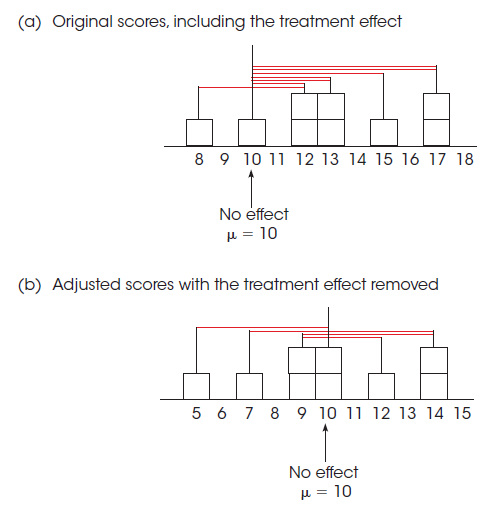

In this example, $ \mu_1 = 13 $ and $ \mu_0 = 10 $

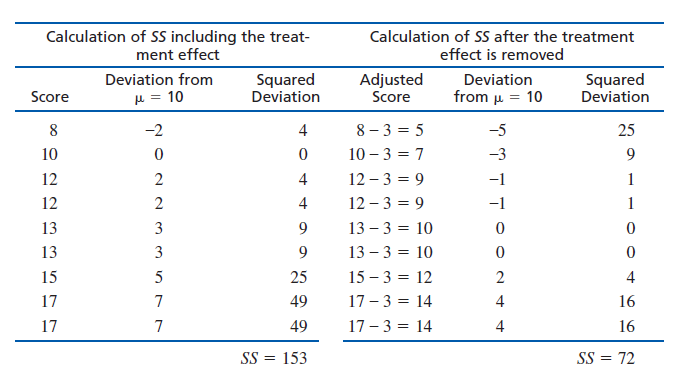

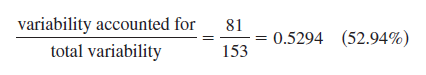

_______________________________

Formula:
$$r^2 (percentage \space variance \space due \space to \space d)= \frac{variability \space explained \space by \space treatment \space effect}{total \space variability \space (of \space H_1 \space from \space \mu_0)}*100$$

$$r^2 = \frac{total \space variability \space (of \space H_1 \space from \space \mu_0) - variability \space of \space (H_1 - d) \space from \mu_0}{total \space variability \space (of \space H_1 \space from \space \mu_0)}*100$$

$asd<sup>superscript text </sup>as$

Where:
- $ \text{total variability} $ : the sum of squared deviations of the sample scores from the expected mean including the treatment

- $ \text{variability explained by treatment effect}  $ : $ \text{total variability} - \text{variability before treatment} $

<br>
Another way of finding it:

$$r^2= \frac{t^2}{t^2 + df}*100$$

| $r^2$           | Effect size              |
|-----------------|--------------------------|
| 0.01            | Small Effect             |
| 0.09            | Medium Effect            |
| 0.25            | Large Effect             |


In [14]:
def sum_squared_deviations_from_expected_mean(scores, expected_mean):
    deviations = scores - expected_mean
    squared_deviations = deviations**2
    ss = np.sum(squared_deviations)
    return  ss


### MAIN ###
treatment_effect = sample_mean - expected_mean
total_variability = sum_squared_deviations_from_expected_mean(scores, expected_mean)
variability_without_treatment_effect = sum_squared_deviations_from_expected_mean(scores - treatment_effect, expected_mean)
variability_explained_by_treatment_effect = total_variability - variability_without_treatment_effect
percentage_variance_explained =  (variability_explained_by_treatment_effect / total_variability) * 100
print(f"Variance explained = {percentage_variance_explained:.2f}%")

percentage_variance_explained_t_value = (t_sample ** 2 / np.sum([t_sample ** 2, df])) * 100
print(f"Variance explained = {percentage_variance_explained_t_value:.2f}%")

Variance explained = 39.92%
Variance explained = 39.92%


#### Confidence interval

A confidence interval is an estimate of a range of values--an interval--around a statistic, e.g. the sample mean, within which the corresponding population parameter should be, e.g. the SDMS mean which is equivalent to the population mean.

$$ CI = \left( \bar{x} - t \times S_M, \bar{x} + t \times S_M \right) $$

Where:

- $ CI $: Confidence Interval.
- $ \bar{x} $: Sample mean.
- $ t $: t-value corresponding to the desired confidence level
- $ S_M $: Standard Error, calculated as:

$$ S_M = \frac{s}{\sqrt{n}} $$

Where:

- $ s $: sample standard deviation

Example of report in the literature: t(8) = 3.00, p < .05, 80% CI [11.603, 14.397].

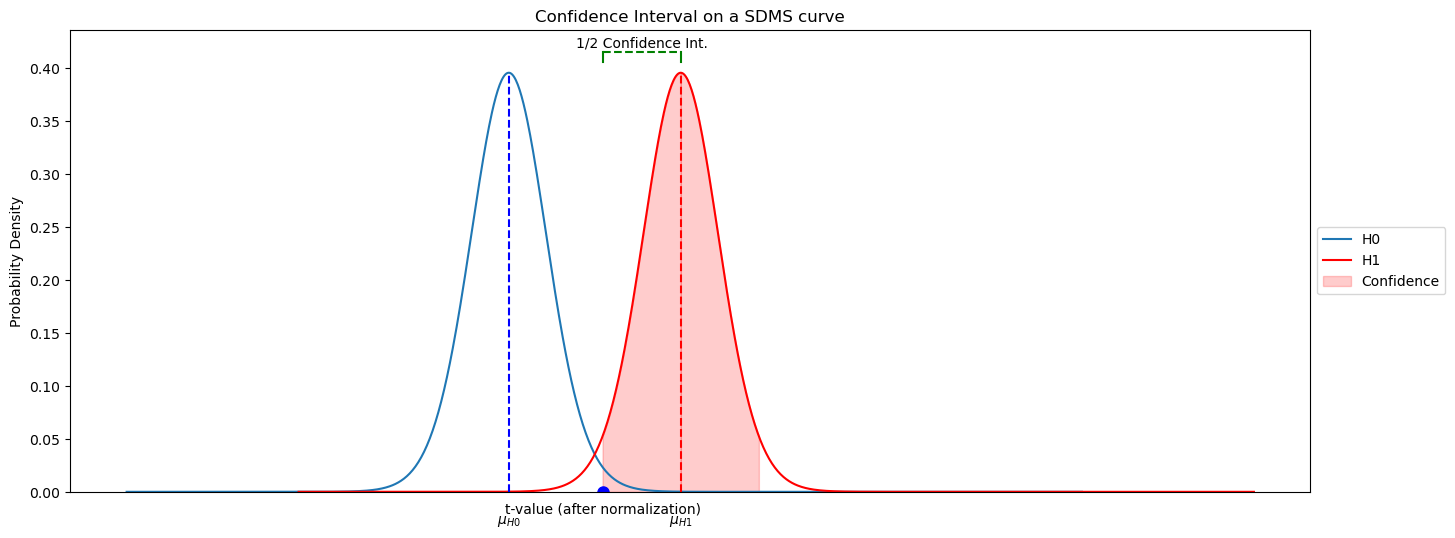

In [15]:
# Define the mean positions for each curve
m0 = 0
m1 = 4.5

# Sample size for t-distribution (you may need to adjust this according to your situation)
n = 30
df = n - 1  # Degrees of freedom for the t-distribution

# Percentage of the shaded area for the red curve
percent_confidence_interval = 95 # %

# Find the t-values corresponding to the shaded area
percent_shaded_tail = (100 - percent_confidence_interval) / 2
t_left = t.ppf(percent_shaded_tail/100, df)
t_right = t.ppf(1 - percent_shaded_tail/100, df)

# Convert t-values to x-values in the shifted curve
x_left_bound = m1 + t_left
x_right_bound = m1 + t_right

# Position for the blue dot: It will be at the left boundary of the shaded region.
blue_dot_position = x_left_bound

# Shading the region for the shifted distribution
x_shaded_custom_left = np.linspace(x_left_bound, m1, 1000)
x_shaded_custom_right = np.linspace(m1, x_right_bound, 1000)
y_shaded_custom_left = t.pdf(x_shaded_custom_left - (m1-m0), df)
y_shaded_custom_right = t.pdf(x_shaded_custom_right - (m1-m0), df)

fig, axes = plt.subplots(1, 1, figsize=(16, 6))

x = np.linspace(-10, 15, 1000)
y = t.pdf(x, df)

axes.plot(x, y, label='H0')
axes.plot(x + (m1-m0), y, label='H1', color='red')
axes.fill_between(x_shaded_custom_left, y_shaded_custom_left, color='red', alpha=0.2, label='Confidence')
axes.fill_between(x_shaded_custom_right, y_shaded_custom_right, color='red', alpha=0.2)

axes.set_title('Confidence Interval on a SDMS curve')
axes.set_ylabel('Probability Density')

# Vertical lines for the means of each curve
y_peak = max(y)
axes.plot([m0, m0], [0, y_peak], color='blue', linestyle='--')
axes.plot([m1, m1], [0, y_peak], color='red', linestyle='--')

# Labels for the vertical lines
axes.text(m0, -0.02, r'$\mu_{H0}$', ha='center', va='top')
axes.text(m1, -0.02, r'$\mu_{H1}$', ha='center', va='top')

# Drawing a horizontal line connecting the peaks of both curves
y_horizontal = y_peak * 1.05
axes.hlines(y_horizontal, x_left_bound, m1, colors='green', linestyles='--')

# Adding smaller ticks at the ends of the horizontal line
tick_length = 0.01
axes.plot([x_left_bound, x_left_bound], [y_horizontal - tick_length, y_horizontal], color='green')
axes.plot([m1, m1], [y_horizontal - tick_length, y_horizontal], color='green')

# Annotating the horizontal line
axes.annotate('1/2 Confidence Int.', xy=((m0 + m1)/2, y_horizontal), xytext=((x_left_bound + m1)/2, y_horizontal + 0.005), ha='center')

# Plotting blue dot and t-value
dot_y = 0  # Directly on top of x-axis
axes.plot(blue_dot_position, dot_y, 'bo', markersize=8)
axes.annotate('t-value (after normalization)', (blue_dot_position, dot_y), textcoords="offset points", xytext=(0,-15), ha='center')

# Turning off x-axis ticks
axes.set_xticks([])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes.grid(False)
axes.set_ylim(0)
plt.show()


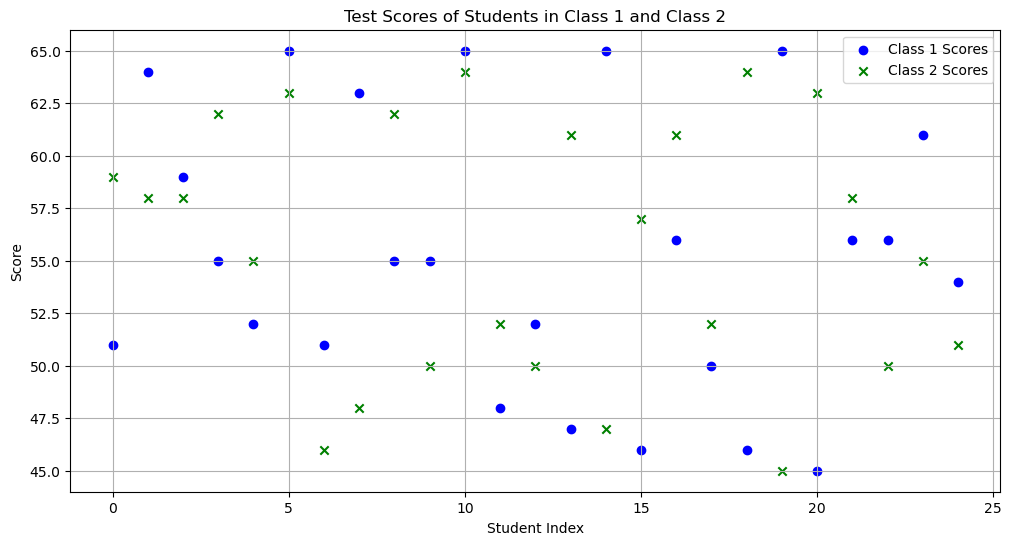

T-statistic: -0.200
P-value: 0.843
Based on the p-value, we fail to reject the null hypothesis. The means of the two classes are not statistically different at alpha=0.05.
